# Introduction to Numpyro

In [15]:
# generate data

import numpy as np

np.random.seed(0)
n, a, b, sigma = 100, 0.5, -1, 0.1

x = np.sort(np.random.normal(0, 1, n))
y = np.exp(a*x + b) + np.random.normal(0, sigma, n)

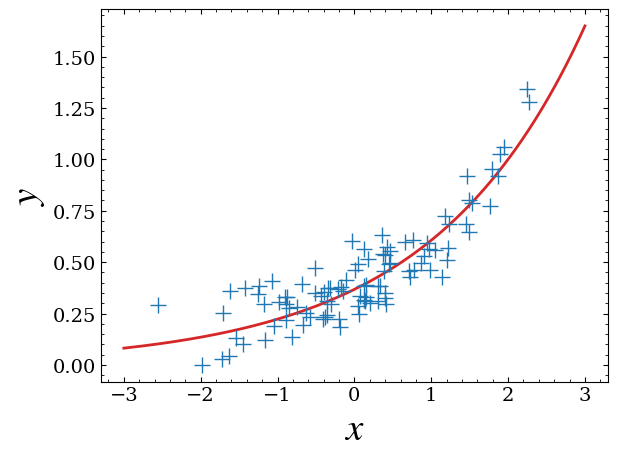

In [16]:
# data visualization

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

x_ = np.linspace(-3, 3, 1000)

plt.plot(x_, np.exp(a*x_ + b), lw=2, color='tab:red')
plt.plot(x, y, '+', markersize=12, color='tab:blue')
plt.xlabel('$x$', size=28)
plt.ylabel('$y$', size=28)
plt.tight_layout()

In [17]:
# define a statistical model

import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

numpyro.set_host_device_count(4) # 4スレッドで並列計算

def model(x, y):
   a = numpyro.sample('a', dist.Uniform(low=-100, high=100))
   b = numpyro.sample('b', dist.Uniform(low=-100, high=100))
   sigma = numpyro.sample('sigma', dist.Uniform(low=0, high=100))
   mu = jnp.exp(a*x + b)
   numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [18]:
# run MCMC

from jax import random
from numpyro.infer import MCMC, NUTS

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples, num_chains = 1000, 2000, 4

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc.run(rng_key_, x=x, y=y)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [19]:
# check the posterior distribution

mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.50      0.03      0.50      0.46      0.54   4881.70      1.00
         b     -0.99      0.03     -0.99     -1.05     -0.94   4551.27      1.00
     sigma      0.11      0.01      0.11      0.09      0.12   1451.08      1.00

Number of divergences: 0


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

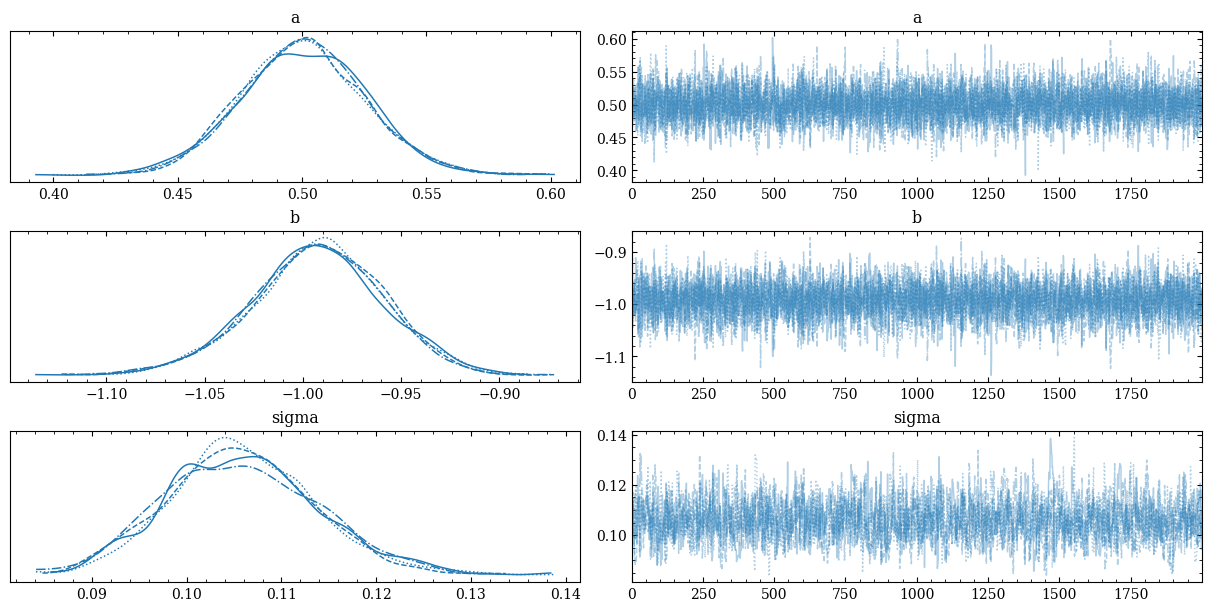

In [20]:
import arviz

arviz.plot_trace(mcmc, var_names=['a', 'b', 'sigma'], backend_kwargs={'constrained_layout': True})

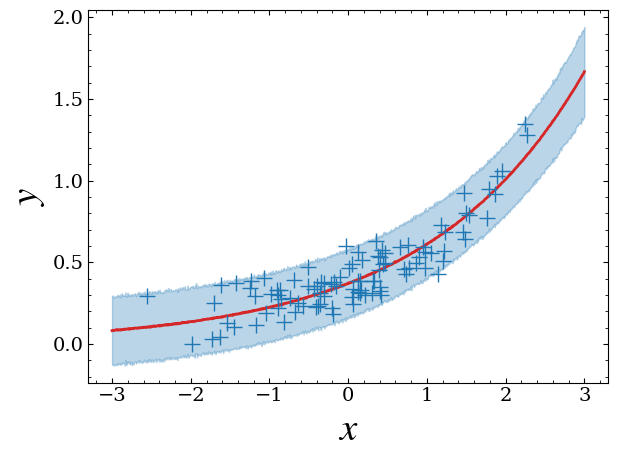

In [21]:
# visualize the predictive distribution

from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

rng_key, rng_key_ = random.split(rng_key)

pred = Predictive(model, mcmc.get_samples(), return_sites=["y"])
x_ = jnp.linspace(-3, 3, 1000)
predictions = pred(rng_key, x=x_, y=None)

mean_y = jnp.mean(predictions['y'], axis=0)
hpdi_y = hpdi(predictions['y'], 0.95)

plt.fill_between(x_, hpdi_y[0], hpdi_y[1], alpha=0.3, color='tab:blue')
plt.plot(x_, mean_y, lw=2, color='tab:red')
plt.plot(x, y, '+', markersize=12, color='tab:blue')
plt.xlabel('$x$', size=28)
plt.ylabel('$y$', size=28)
plt.tight_layout()